In [1]:
# https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/
import os 
import tensorflow as tf 
import numpy as np 
import seaborn as sns 
import pathlib 
from IPython import display 
from matplotlib import pyplot as plt 
from sklearn.metrics import classification_report
%matplotlib inline

In [2]:
# Using audio_dataset_from_directory function to create dataset with audio data 
training_set, validation_set = tf.keras.utils.audio_dataset_from_directory( 
	directory='mini_speech_commands', 
	batch_size=16, 
	validation_split=0.2, 
	output_sequence_length=16000, 
	seed=0, 
	subset='both') 

# Extracting audio labels 
label_names = np.array(training_set.class_names) 
print("label names:", label_names)


Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.
label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [3]:
# Defining the squeeze function 
def squeeze(audio, labels): 
  audio = tf.squeeze(audio, axis=-1) 
  return audio, labels 
  
# Applying the function on the dataset obtained from previous step 
training_set = training_set.map(squeeze, tf.data.AUTOTUNE) 
validation_set = validation_set.map(squeeze, tf.data.AUTOTUNE)

In [4]:
# Visualize the waveform 
audio, label = next(iter(training_set)) 
display.display(display.Audio(audio[0], rate=16000))

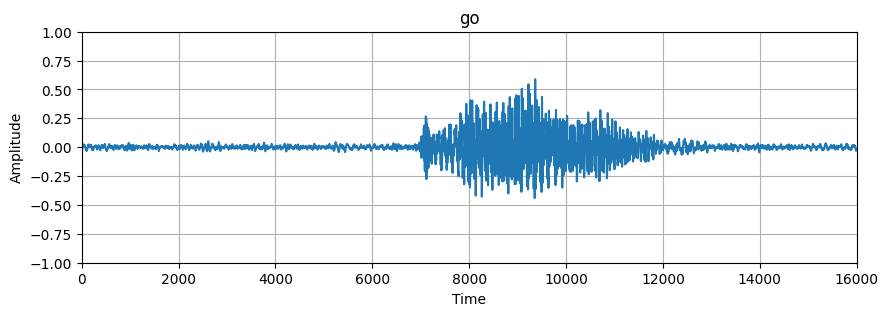

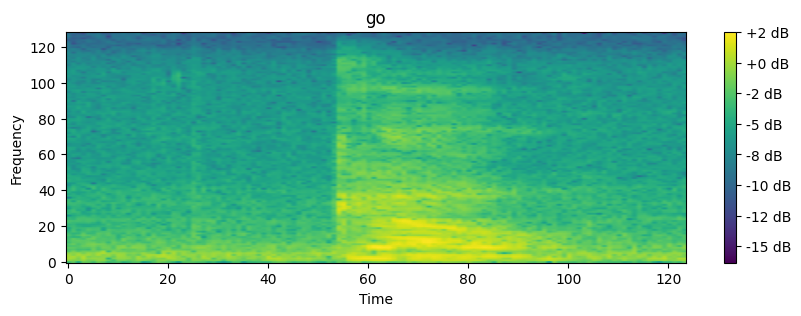

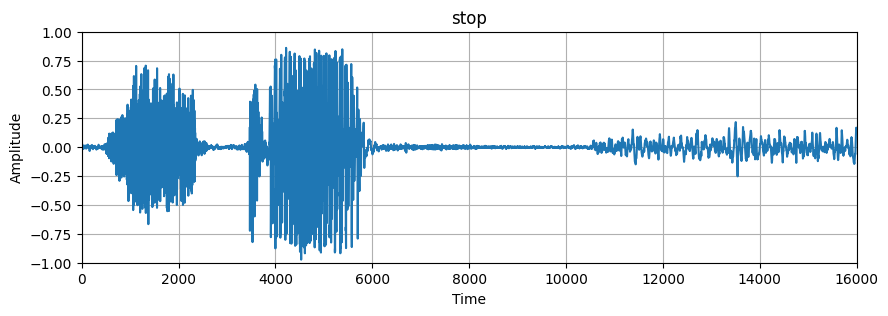

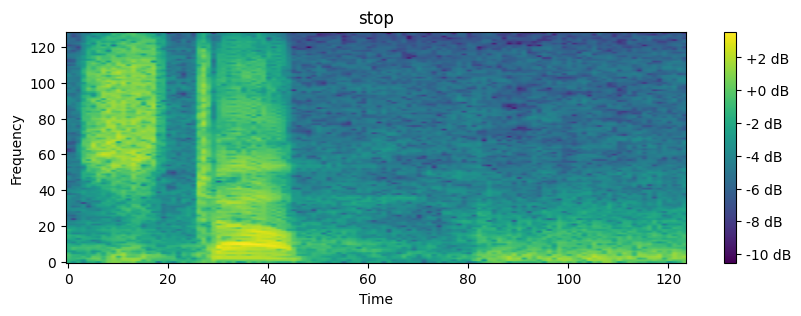

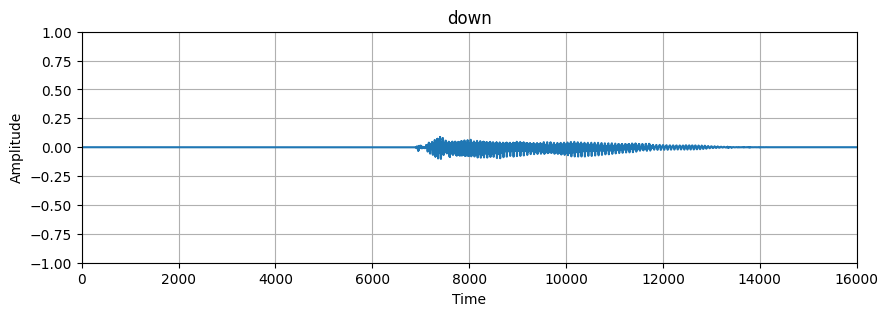

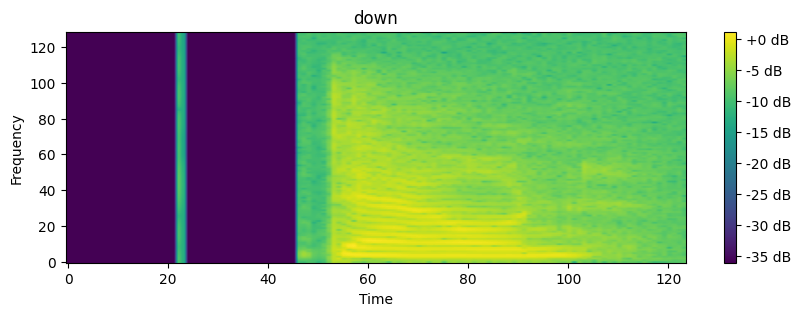

In [21]:
# Plot the waveform 
def plot_wave(waveform, label): 
	plt.figure(figsize=(10, 3)) 
	plt.title(label) 
	plt.plot(waveform) 
	plt.xlim([0, 16000]) 
	plt.ylim([-1, 1]) 
	plt.xlabel('Time') 
	plt.ylabel('Amplitude') 
	plt.grid(True) 

# Convert waveform to spectrogram 
def get_spectrogram(waveform): 
	spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128) 
	spectrogram = tf.abs(spectrogram) 
	return spectrogram[..., tf.newaxis] 

# Plot the spectrogram 
def plot_spectrogram(spectrogram, label): 
	spectrogram = np.squeeze(spectrogram, axis=-1) 
	log_spec = np.log(spectrogram.T + np.finfo(float).eps) 
	plt.figure(figsize=(10, 3)) 
	plt.title(label) 
	plt.imshow(log_spec, aspect='auto', origin='lower') 
	plt.colorbar(format='%+2.0f dB') 
	plt.xlabel('Time') 
	plt.ylabel('Frequency') 

for i in range(3):
    # Plotting the waveform and the spectrogram of a random sample 
    audio, label = next(iter(training_set)) 
    
    # Plot the wave with its label name 
    plot_wave(audio[i], label_names[label[i]]) 
    
    # Plot the spectrogram with its label name 
    plot_spectrogram(get_spectrogram(audio[i]), label_names[label[i]])

In [6]:
# Creating spectrogram dataset from waveform or audio data 
def get_spectrogram_dataset(dataset): 
	dataset = dataset.map( 
		lambda x, y: (get_spectrogram(x), y), 
		num_parallel_calls=tf.data.AUTOTUNE) 
	return dataset 

# Applying the function on the audio dataset 
train_set = get_spectrogram_dataset(training_set) 
validation_set = get_spectrogram_dataset(validation_set) 

# Dividing validation set into two equal val and test set 
val_set = validation_set.take(validation_set.cardinality() // 2) 
test_set = validation_set.skip(validation_set.cardinality() // 2)

In [7]:
train_set_shape = train_set.element_spec[0].shape 
val_set_shape = val_set.element_spec[0].shape 
test_set_shape = test_set.element_spec[0].shape 

print("Train set shape:", train_set_shape) 
print("Validation set shape:", val_set_shape) 
print("Testing set shape:", test_set_shape)

Train set shape: (None, 124, 129, 1)
Validation set shape: (None, 124, 129, 1)
Testing set shape: (None, 124, 129, 1)


# *Можно создать последовательную модель*

In [29]:
# Defining the model 
def get_model(input_shape, num_labels): 
	model = tf.keras.Sequential([ 
		tf.keras.layers.Input(shape=input_shape), 
		# Resizing the input to a square image of size 64 x 64 and normalizing it 
		tf.keras.layers.Resizing(64, 64), 
		tf.keras.layers.Normalization(), 
		
		# Convolution layers followed by MaxPooling layer 
		tf.keras.layers.Conv2D(64, 3, activation='relu'), 
		tf.keras.layers.Conv2D(128, 3, activation='relu'), 
        tf.keras.layers.Conv2D(256, 3, activation='relu'),
		tf.keras.layers.MaxPooling2D(), 
		tf.keras.layers.Dropout(0.5), 
		tf.keras.layers.Flatten(), 
		
		# Dense layer 
        tf.keras.layers.Dense(512, activation='relu'),
		tf.keras.layers.Dense(256, activation='relu'), 
		tf.keras.layers.Dropout(0.5), 
		
		# Softmax layer to get the label prediction 
		tf.keras.layers.Dense(num_labels, activation='softmax') 
	]) 
	# Printing model summary 
	model.summary() 
	return model 

# Getting input shape from the sample audio and number of classes 
input_shape = next(iter(train_set))[0][0].shape 
print("Input shape:", input_shape) 
num_labels = len(label_names) 

# Creating a model 
model = get_model(input_shape, num_labels)

Input shape: (124, 129, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 64, 64, 1)         0         
                                                                 
 normalization_3 (Normaliza  (None, 64, 64, 1)         3         
 tion)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 62, 62, 64)        640       
                                                                 
 conv2d_31 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 conv2d_32 (Conv2D)          (None, 58, 58, 256)       295168    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 29, 29, 256)       0         
 g2D)                      

# *Или можно создать ResNet-подобную модель*

In [22]:
# https://proproprogs.ru/tensorflow/keras-sozdaem-resnet-podobnuyu-arhitekturu-dlya-klassifikacii-izobrazheniy-cifar-10
from tensorflow import keras
from tensorflow.keras import layers

input_shape = next(iter(train_set))[0][0].shape 
print("Input shape:", input_shape) 
num_labels = len(label_names) 


inputs = keras.Input(shape=input_shape, name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])
x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])
x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_labels, activation='softmax')(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
model.summary()

Input shape: (124, 129, 1)
Model: "toy_resnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 124, 129, 1)]        0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 122, 127, 32)         320       ['img[0][0]']                 
                                                                                                  
 conv2d_21 (Conv2D)          (None, 120, 125, 64)         18496     ['conv2d_20[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 40, 41, 64)           0         ['conv2d_21[0][0]']           
 g2D)                                                         

In [30]:
model.compile( 
	optimizer=tf.keras.optimizers.Adam(), 
	loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
	metrics=['accuracy'], 
) 

EPOCHS = 10
history = model.fit( 
	train_set, 
	validation_data=val_set, 
	epochs=EPOCHS, 
)

Epoch 1/10
400/400 [==============================] - 403s 1s/step - loss: 1.4670 - accuracy: 0.4719 - val_loss: 0.8876 - val_accuracy: 0.7150
Epoch 2/10
400/400 [==============================] - 399s 997ms/step - loss: 0.7097 - accuracy: 0.7528 - val_loss: 0.6048 - val_accuracy: 0.7825
Epoch 3/10
400/400 [==============================] - 396s 988ms/step - loss: 0.4712 - accuracy: 0.8355 - val_loss: 0.4345 - val_accuracy: 0.8612
Epoch 4/10
400/400 [==============================] - 395s 987ms/step - loss: 0.3363 - accuracy: 0.8831 - val_loss: 0.4788 - val_accuracy: 0.8575
Epoch 5/10
400/400 [==============================] - 395s 987ms/step - loss: 0.2835 - accuracy: 0.9028 - val_loss: 0.4224 - val_accuracy: 0.8662
Epoch 6/10
400/400 [==============================] - 396s 990ms/step - loss: 0.2261 - accuracy: 0.9241 - val_loss: 0.3797 - val_accuracy: 0.8775
Epoch 7/10
400/400 [==============================] - 395s 987ms/step - loss: 0.1833 - accuracy: 0.9392 - val_loss: 0.4213 - va

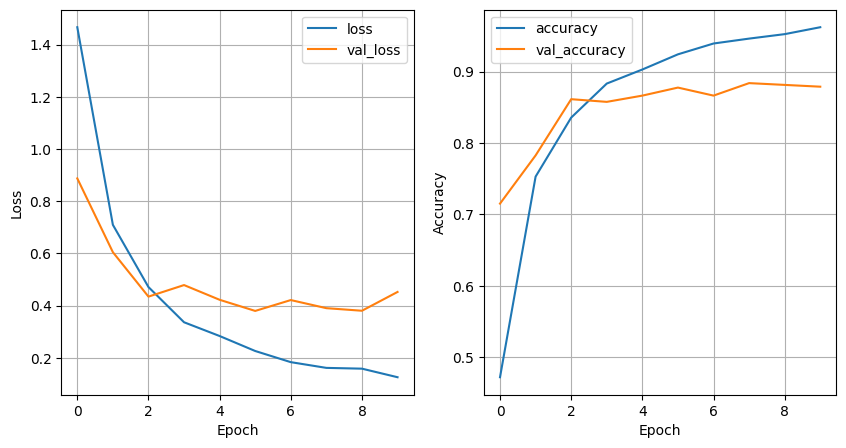

In [31]:
# Plotting the history 
metrics = history.history 
plt.figure(figsize=(10, 5)) 

# Plotting training and validation loss 
plt.subplot(1, 2, 1) 
plt.plot(history.epoch, metrics['loss'], metrics['val_loss']) 
plt.legend(['loss', 'val_loss']) 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.grid()

# Plotting training and validation accuracy 
plt.subplot(1, 2, 2) 
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy']) 
plt.legend(['accuracy', 'val_accuracy']) 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy')
plt.grid()

50/50 [==============================] - 6s 104ms/step


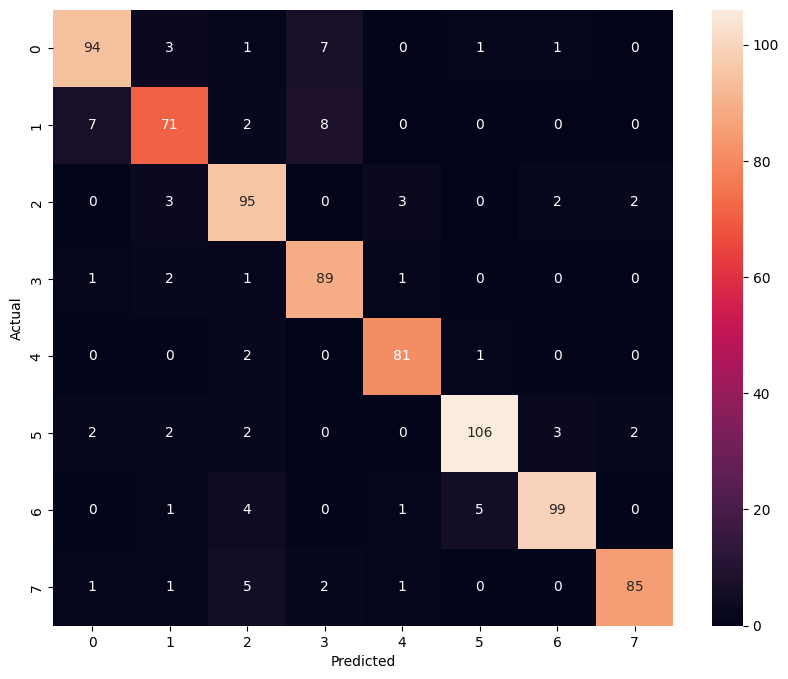

In [32]:
# Confusion matrix 
y_pred = np.argmax(model.predict(test_set), axis=1) 
y_true = np.concatenate([y for x, y in test_set], axis=0) 
cm = tf.math.confusion_matrix(y_true, y_pred) 

# Plotting the confusion matrix 
plt.figure(figsize=(10, 8)) 
sns.heatmap(cm, annot=True, fmt='g') 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()

In [33]:
report = classification_report(y_true, y_pred) 
print(report)

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       107
           1       0.86      0.81      0.83        88
           2       0.85      0.90      0.88       105
           3       0.84      0.95      0.89        94
           4       0.93      0.96      0.95        84
           5       0.94      0.91      0.92       117
           6       0.94      0.90      0.92       110
           7       0.96      0.89      0.92        95

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800



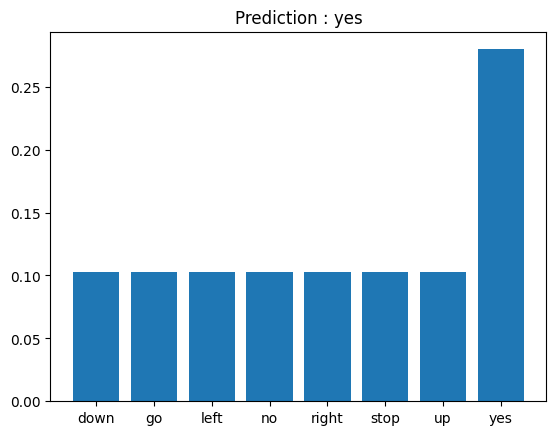

In [28]:
path = 'mini_speech_commands/yes/0f7dc557_nohash_0.wav'
Input = tf.io.read_file(str(path)) 
x, sample_rate = tf.audio.decode_wav(Input, desired_channels=1, desired_samples=16000,) 
audio, labels = squeeze(x, 'yes') 

waveform = audio 
display.display(display.Audio(waveform, rate=16000)) 

x = get_spectrogram(audio) 
x = tf.expand_dims(x, axis=0) 

prediction = model(x) 
plt.bar(label_names, tf.nn.softmax(prediction[0])) 
plt.title('Prediction : '+ label_names[np.argmax(prediction, axis=1).item()]) 
plt.show()